In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 110      # sharper plots

RAW_EVENT_PATH     = "/Users/gillianmondero/Downloads/event_logs.csv"
RAW_MARKETING_PATH = "/Users/gillianmondero/Downloads/marketing_summary.csv"
RAW_TREND_PATH     = "/Users/gillianmondero/Downloads/trend_report.csv"

event_raw     = pd.read_csv(RAW_EVENT_PATH)
marketing_raw = pd.read_csv(RAW_MARKETING_PATH, parse_dates=["date"])
trend_raw     = pd.read_csv(RAW_TREND_PATH)

print("Raw datasets loaded:")
print(f"  • event_logs.csv      : {len(event_raw):,} rows")
print(f"  • marketing_summary   : {len(marketing_raw):,} rows")
print(f"  • trend_report        : {len(trend_raw):,} rows")

Raw datasets loaded:
  • event_logs.csv      : 2,000 rows
  • marketing_summary   : 100 rows
  • trend_report        : 20 rows


In [3]:
event_raw     = pd.read_csv(RAW_EVENT_PATH)
marketing_raw = pd.read_csv(RAW_MARKETING_PATH, parse_dates=["date"])
trend_raw     = pd.read_csv(RAW_TREND_PATH)

print("\n[STEP 1] Raw rows loaded")
print(f"  • event_logs.csv        : {len(event_raw):,}")
print(f"  • marketing_summary.csv : {len(marketing_raw):,}")
print(f"  • trend_report.csv      : {len(trend_raw):,}")


[STEP 1] Raw rows loaded
  • event_logs.csv        : 2,000
  • marketing_summary.csv : 100
  • trend_report.csv      : 20


In [5]:
def clean_event(df: pd.DataFrame) -> pd.DataFrame:
    out = (df
           .drop_duplicates()
           .assign(event_time=lambda d: pd.to_datetime(d["event_time"],
                                                      errors="coerce"))
           .dropna(subset=["event_time", "event_type", "product_id"])
           .assign(amount=lambda d: np.where(
               (d["event_type"].str.lower() == "checkout") & (d["amount"].isna()),
               np.nan,
               d["amount"].fillna(0)
           ))
           .dropna(subset=["amount"])
           .astype({"amount": "float64"}))
    return out

def clean_marketing(df: pd.DataFrame) -> pd.DataFrame:
    out = (df
           .drop_duplicates(subset=["date"])
           .fillna({"users_active": 0,
                    "new_customers": 0,
                    "total_sales": 0,
                    "col_7": 0})
           .astype({"users_active": "int32",
                    "new_customers": "int32",
                    "total_sales": "float64",
                    "col_7": "float64"}))
    return out

def clean_trend(df: pd.DataFrame) -> pd.DataFrame:
    out = (df
           .drop_duplicates(subset=["week"])
           .astype({"avg_users": "float64"}))
    out["avg_users"] = out["avg_users"].replace(0, np.nan).ffill()
    return out

event_df     = clean_event(event_raw)
marketing_df = clean_marketing(marketing_raw)
trend_df     = clean_trend(trend_raw)

print("Rows after cleaning")
print(f"  • event_logs         : {len(event_df):,}")
print(f"  • marketing_summary  : {len(marketing_df):,}")
print(f"  • trend_report       : {len(trend_df):,}")

print("\nPreview of cleaned marketing_summary:")
print(marketing_df.head())

Rows after cleaning
  • event_logs         : 1,858
  • marketing_summary  : 100
  • trend_report       : 20

Preview of cleaned marketing_summary:
        date  users_active  total_sales  new_customers  report_generated  \
0 2023-06-01           179     81287.31              9  2023-06-01 16:00   
1 2023-06-02            67     74771.99              5  2023-06-02 16:00   
2 2023-06-03           369     84809.74             11  2023-06-03 16:00   
3 2023-06-04            94     61212.30              3  2023-06-04 16:00   
4 2023-06-05           402     80911.49             10  2023-06-05 16:00   

   col_6   col_7   col_8  col_9  col_10  ...  col_41 col_42  col_43  col_44  \
0  North  519.37     NaN  North  987.06  ...  4662.0   West     NaN   756.0   
1   East    0.00    75.0  South  916.36  ...     NaN   West  457.14     NaN   
2    NaN  512.79  2643.0   East  420.43  ...  2839.0  South  161.89  3339.0   
3  South    0.00  1264.0  North   16.13  ...  2509.0  North  661.14     NaN   
4

In [9]:
latest = marketing_df.loc[marketing_df["date"].idxmax()]

dau               = int(latest["users_active"])
conv_rate_pct     = latest["new_customers"] / latest["users_active"] * 100
trend_sorted      = trend_df.sort_values("week")
au_prev, au_cur   = trend_sorted["avg_users"].tail(2)
churn_pct         = max(0, (au_prev - au_cur) / au_prev) * 100
top_sales         = (event_df[event_df["event_type"].str.lower() == "checkout"]
                     .groupby("product_id")["amount"]
                     .sum()
                     .max())
spend_pesos       = latest["col_7"]
profit_margin_pct = ((latest["total_sales"] - spend_pesos)
                     / latest["total_sales"] * 100 if latest["total_sales"] else 0)
err_events        = event_df["event_type"].str.contains(r"error|failed",
                                                        case=False, na=False).sum()
sys_err_rate_pct  = err_events / len(event_df) * 100

print("KPI values")
print(f"  Daily Active Users            : {dau:,}")
print(f"  Conversion Rate (%)           : {conv_rate_pct:,.2f}%")
print(f"  Churn Prediction Score (%)    : {churn_pct:,.2f}%")
print(f"  Top Product Sales (₱)         : {top_sales:,.2f}")
print(f"  Campaign Profit Margin (%)    : {profit_margin_pct:,.2f}%")
print(f"  System Error Rate (%)         : {sys_err_rate_pct:,.2f}%")

KPI values
  Daily Active Users            : 80
  Conversion Rate (%)           : 7.50%
  Churn Prediction Score (%)    : 0.00%
  Top Product Sales (₱)         : 13,204.74
  Campaign Profit Margin (%)    : 99.61%
  System Error Rate (%)         : 0.00%


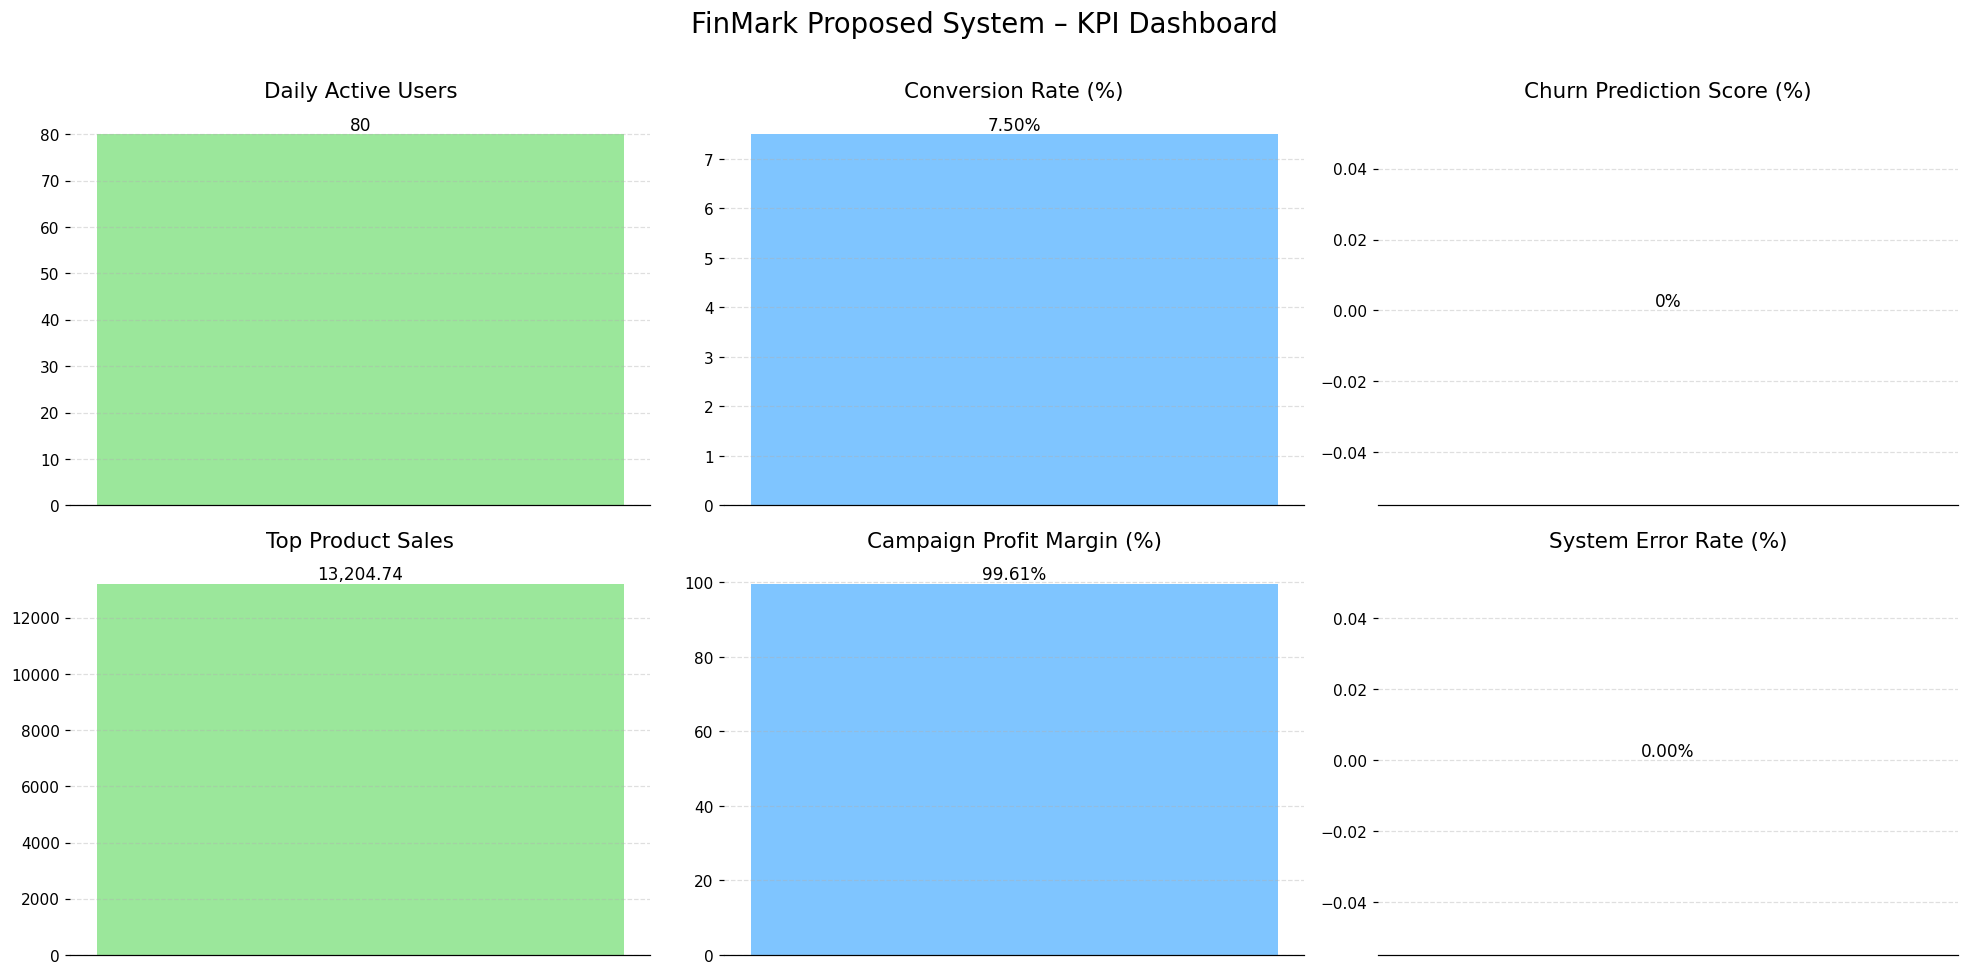

In [11]:
kpi_vals = [dau,
            conv_rate_pct,
            churn_pct,
            top_sales,
            profit_margin_pct,
            sys_err_rate_pct]

kpi_lbls = ["Daily Active Users",
            "Conversion Rate (%)",
            "Churn Prediction Score (%)",
            "Top Product Sales",
            "Campaign Profit Margin (%)",
            "System Error Rate (%)"]

bar_cols = ["#9be79b", "#7fc5ff", "#7fc5ff",
            "#9be79b", "#7fc5ff", "#7fc5ff"]

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

for ax, val, lbl, col in zip(axes, kpi_vals, kpi_lbls, bar_cols):
    ax.bar(lbl, val, color=col)
    ax.set_title(lbl, fontsize=14, pad=12)
    ax.set_xticks([])
    ax.grid(axis="y", linestyle="--", alpha=.4)
    for s in ["top", "right", "left"]:
        ax.spines[s].set_visible(False)
    suffix = "%" if "Rate" in lbl or "Score" in lbl or "Margin" in lbl else ""
    ax.text(0, val,
            f"{val:,.2f}{suffix}" if not isinstance(val, int) else f"{val:,}{suffix}",
            ha="center", va="bottom", fontsize=11)

fig.suptitle("FinMark Proposed System – KPI Dashboard", fontsize=18, y=.98)
plt.tight_layout(rect=[0, 0, 1, .97])
plt.show()